In [1]:
from google.colab import drive, files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Activation, Softmax, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications import EfficientNetV2B0, VGG16
import pickle

## Carga y preparación del conjunto de datos:

In [2]:
# Nos aseguramos que tenemos instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/79.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102969 sha256=dde43703d13dba9da9982ace3a17b2e8df58abfeb0f1eff87fdf9de40cedb518
  Stored in directory: /root/.cache/pip/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.12
    Uninstalling kaggle-1.6.12:
      Successfully uninstalled kaggle-1.6.12


In [3]:
drive.mount('/content/drive')
# Seleccionamos el API Token personal previamente descargado (fichero kaggle.json)
files.upload()
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Descargamos el dataset que nos fue asignado
!kaggle datasets download -d gpiosenka/100-bird-species
# Creemos un directorio para descomprimir los datos
!mkdir dataset
!unzip -q 100-bird-species.zip -d dataset

Mounted at /content/drive


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
License(s): CC0-1.0
100% 1.96G/1.96G [00:54<00:00, 43.6MB/s]
100% 1.96G/1.96G [00:54<00:00, 38.5MB/s]


In [ ]:
BASE_FOLDER = '/content/drive/'

In [ ]:
# Normalizamos y ajustamos el data augmentation para usarlo en los generadores
data_augmentation = True

if data_augmentation:
    train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest"
    )
else:
    train_datagen = ImageDataGenerator(rescale=1 / 255.0)

valid_datagen = ImageDataGenerator(rescale=1 / 255.0)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

# Tamaño de batches para cada set
train_batch = 128
valid_batch = 64
test_batch = 64

# Cargar los datos usando los generadores de flujo de directorio
# Reducimos el tamaño de las imágenes de train para agilizar el entrenamiento (recomendado en la web del dataset)
train_generator = train_datagen.flow_from_directory(
    directory="dataset/train/",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=train_batch,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_generator = valid_datagen.flow_from_directory(
    directory="dataset/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=valid_batch,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory="dataset/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=test_batch,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
num_class = train_generator.class_indices
print(f"Número de clases: {len(num_class)}")

Número de clases: 525


Found 2625 images belonging to 525 classes.


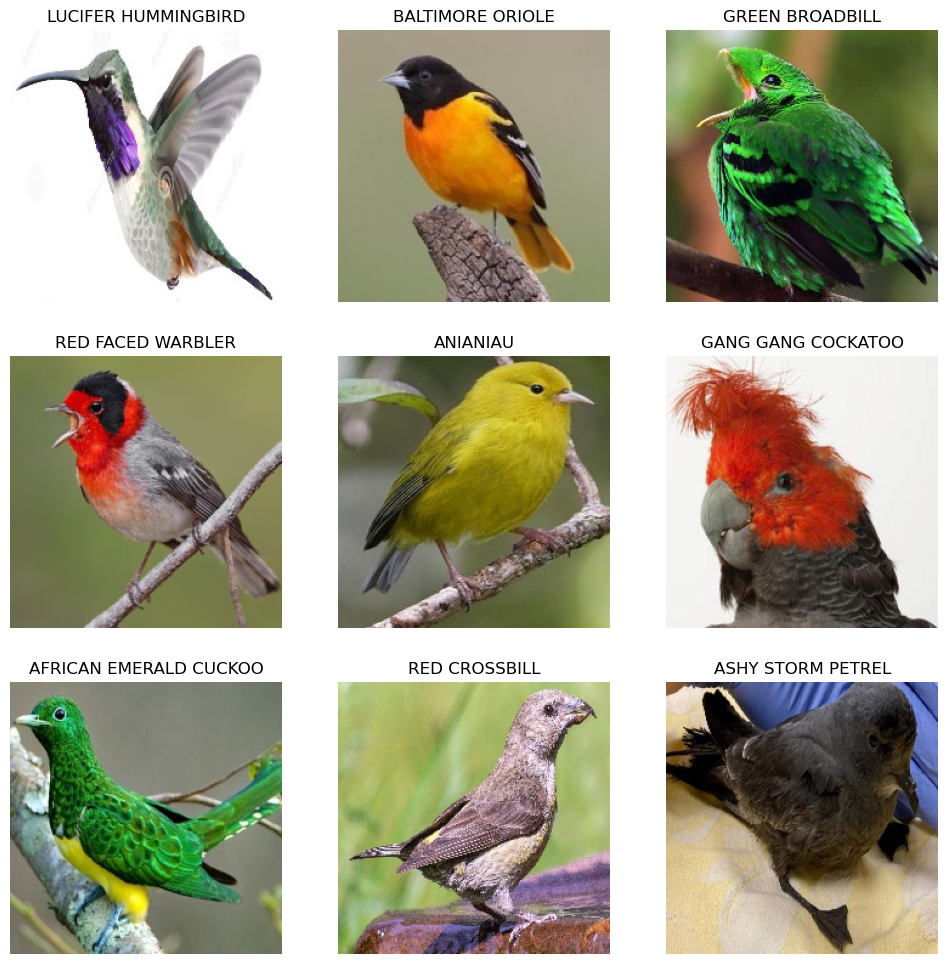

In [ ]:
# Creamos un generador sin data augmentation para mostrar ejemplos de imágenes de distintos tipos de aves
datagen_no_augmentation = ImageDataGenerator(rescale=1 / 255.0)

original_generator = datagen_no_augmentation.flow_from_directory(
    directory="dataset/valid/",
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=True
)

images, labels = next(original_generator)
class_names = list(original_generator.class_indices.keys())

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

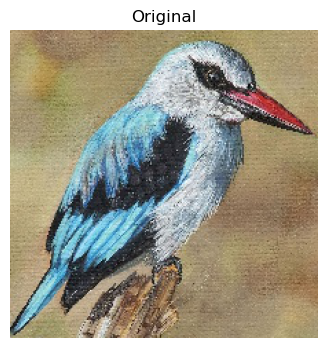

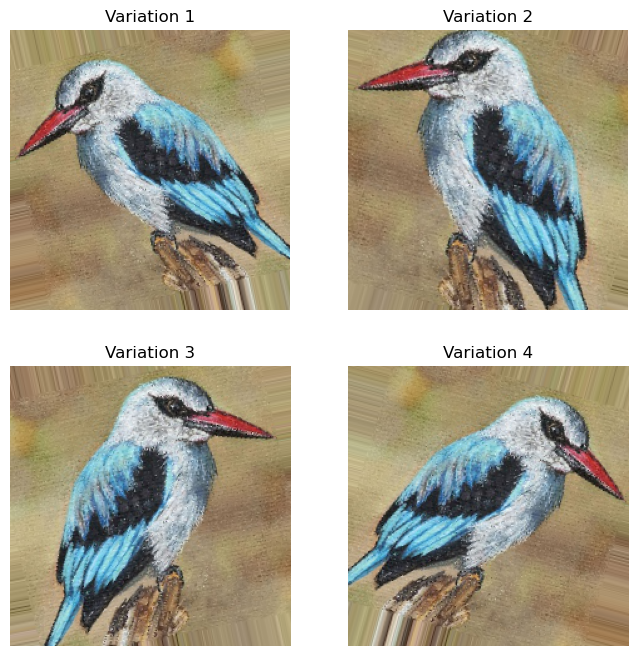

In [ ]:
# Mostramos una imagen original y 4 variaciones segun el data augmentation
image_original, label = next(original_generator)

plt.figure(figsize=(4, 4))
plt.imshow(image_original[0])
plt.title("Original")
plt.axis("off")
plt.show()

augmented_images = []
num_variations = 4

for _ in range(num_variations):
    augmented_img = train_datagen.random_transform(image_original[0])
    augmented_images.append(augmented_img)

plt.figure(figsize=(8, 8))

for i in range(num_variations):
    plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Variation {i+1}")
    plt.axis("off")

plt.show()

## Desarrollo y entrenamiento de la estrategia 1 (From Scratch):

In [ ]:
# BASE MODEL

# Definimos entradas
inputs = Input(shape=(150, 150, 3))

# Primer bloque convolucional CONV => RELU => CONV => RELU => POOL
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
x1 = BatchNormalization()(x1)
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)

# Segundo bloque convolucional CONV => RELU => CONV => RELU => POOL
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x1)
x2 = BatchNormalization()(x2)
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.25)(x2)

# Tercer bloque convolucional CONV => RELU => CONV => RELU => POOL
x3 = Conv2D(128, (3, 3), padding="same", activation="relu")(x2)
x3 = BatchNormalization()(x3)
x3 = Conv2D(128, (3, 3), padding="same", activation="relu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)
x3 = Dropout(0.25)(x3)

# Cuarto bloque convolucional CONV => RELU => CONV => RELU => POOL
x4 = Conv2D(256, (3, 3), padding="same", activation="relu")(x3)
x4 = BatchNormalization()(x4)
x4 = Conv2D(256, (3, 3), padding="same", activation="relu")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(2, 2))(x4)
x4 = Dropout(0.25)(x4)

# Global Pooling (previo al Top Model)
global_pooling = GlobalMaxPooling2D()(x4)

# TOP MODEL
# Primer (y único) set de capas FC => RELU
xfc = Flatten()(global_pooling) #(X)
xfc = BatchNormalization()(xfc) #(X) ¿necesario? -> no está detrás de una capa de activación.
xfc = Dense(512, activation="relu")(xfc) #(X)
xfc = BatchNormalization()(xfc) #(X)
xfc = Dropout(0.3)(xfc) #(X)
# Clasificador softmax
predictions = Dense(525, activation="softmax")(xfc) #(X)

# Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs
model_cnn = Model(inputs=inputs, outputs=predictions) #(X)

In [ ]:
model_cnn.summary()  # Resumen del modelo

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0     

In [ ]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")

# EarlyStopping para que deje de entrenar si se produce overfitting
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               mode = "min",
                               restore_best_weights = False)

# ReduceLROnPlateau para que reduzca el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.2, patience=2, min_lr=1e-6)

optimizer = Adam(learning_rate=0.001)

model_cnn.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

[INFO]: Compilando el modelo...


In [ ]:
# Entrenamiento de la red
n_epochs = 25

print("[INFO]: Entrenando la red...")
H = model_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_batch,
    epochs=n_epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_batch,
    callbacks = [reduce_lr, early_stopping]
)

[INFO]: Entrenando la red...
Epoch 1/25
661/661 [==============================] - 439s 653ms/step - loss: 4.3447 - accuracy: 0.1572 - val_loss: 3.3514 - val_accuracy: 0.2641 - lr: 0.0010
Epoch 2/25
661/661 [==============================] - 412s 623ms/step - loss: 2.4035 - accuracy: 0.4578 - val_loss: 1.9929 - val_accuracy: 0.5324 - lr: 0.0010
Epoch 3/25
661/661 [==============================] - 412s 623ms/step - loss: 1.7257 - accuracy: 0.5927 - val_loss: 1.7091 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 4/25
661/661 [==============================] - 407s 616ms/step - loss: 1.3980 - accuracy: 0.6626 - val_loss: 1.2960 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 5/25
661/661 [==============================] - 455s 688ms/step - loss: 1.1895 - accuracy: 0.7062 - val_loss: 1.2077 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 6/25
661/661 [==============================] - 408s 616ms/step - loss: 1.0539 - accuracy: 0.7348 - val_loss: 1.1609 - val_accuracy: 0.7157 - lr: 0.0010
Epoch 7/25
661/66

In [ ]:
# Montamos la unidad de Drive
drive.mount('/content/drive')

# Almacenamos el modelo y el historial del entrenamiento
with open('scratch_history.pkl', 'wb') as file:
    pickle.dump(H.history, file)

model_cnn.save(BASE_FOLDER+"scratch_model.h5")

# model_cnn = tf.keras.models.load_model(BASE_FOLDER+'scratch_model.h5')

#### **- Observando el proceso de entrenamiento para tomar decisiones**

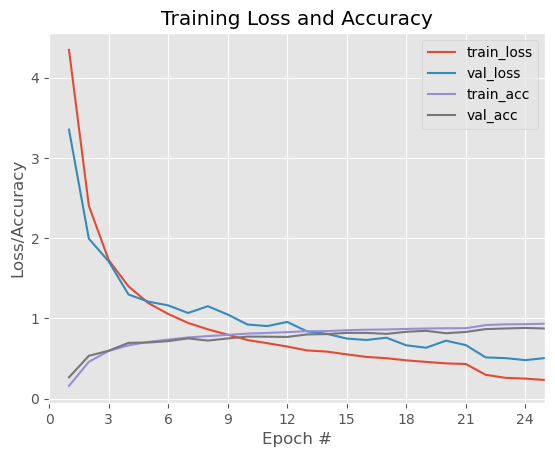

In [ ]:
# Gráficas con datos de historial de entrenamiento del generador
plt.style.use("ggplot")
plt.figure()
epochs_plt = np.arange(1, n_epochs + 1)  # Crear un rango de 1 a n_epochs
plt.plot(epochs_plt, H.history["loss"], label="train_loss")
plt.plot(epochs_plt, H.history["val_loss"], label="val_loss")
plt.plot(epochs_plt, H.history["accuracy"], label="train_acc")
plt.plot(epochs_plt, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim([0, n_epochs])
plt.legend()
plt.show()

In [ ]:
# Evaluación del modelo con generadores de flujo de datos
print("[INFO]: Evaluando el modelo...")
test_loss, test_accuracy = model_cnn.evaluate(test_generator)

# Imprimir la pérdida y precisión en el conjunto de prueba
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

[INFO]: Evaluando el modelo...
42/42 [==============================] - 5s 121ms/step - loss: 0.4372 - accuracy: 0.8869
Test Loss: 0.43719470500946045
Test Accuracy: 0.8868571519851685


#### **- Probando el conjunto de datos en el subset de test y evaluando el performance del modelo**

In [ ]:
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = model_cnn.predict(test_generator, verbose=1)

# Obtenemos las etiquetas reales (ground truth)
y_test = []
for i in range(len(test_generator)):
    batch = test_generator[i]
    y_test.extend(np.argmax(batch[1], axis=1))

# Obtenemos las etiquetas predichas
y_pred = np.argmax(predictions, axis=1)

# Generamos el informe de clasificación
print(classification_report(y_test, y_pred, zero_division=1))

[INFO]: Evaluando red neuronal...
42/42 [==============================] - 4s 79ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.40      0.57         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       0.83      1.00      0.91         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.60      0.75         5
          13       0.83      1.00      0.91         5
          14       1.00      0.80      0.89         5
          15       0.71      1.00      0.83    

### Justificación


1. Los entrenamientos se tuvieron que realizar en local por falta de recursos en Colab, aún así no contábamos con GPUs de gran potencia por lo que se hizo una reducción del tamaño de las imágenes en el conjunto de train para los entrenamientos.
2. Se empezó el entrenamiento con una estructura de 3 bloques, pero no logramos hacer que la red superase un accuracy del 0.75, para ello añadimos un nuevo bloque formando una arquitectura de 4 bloques.
3. Para no sobreentrenar la red y no obtener millones de parámetros se hizo uso de GlobalMaxPooling antes del Top Model.
4. Al principio con 4 bloques obteníamos cierto sobreentrenamiento, llegando a un accuracy en train de más del 0.92 pero un escaso 0.70 en validación. Para reducir este sobreentrenamiento añadimos weight regularization (L1 y L2) pero los resultados no mejoraban mucho, por lo que finalmente, quitamos weight regularization y añadimos dropout ajustando su valor para obtener los resultados que se muestran anteriormente. 
5. Probamos con la codificación sparse para el dataset, pero observó empíricamente y se constató también en búsquedas en foros especializados, que se obtenían mejores resultados si se codificaban los datos empleando OHE y se utilizaba su función de pérdida correspondiente.


## Desarrollo y entrenamiento de la estrategia 2 (Pre-entrenada):

### TRASFER LEARNING: EfficientNetV2B0

In [ ]:
# Normalizamos las entradas de idéntica forma a como lo hicieron para entrenar efficientnet_v2 en imageNet y añadimos data augmentation
data_augmentation = True

if data_augmentation:
    train_datagen = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input,
        rotation_range=10,
        zoom_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest"
    )

else:
    train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input
)


valid_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input
)

# Tamaño de batches para cada set
train_batch = 128
valid_batch = 64
test_batch = 64

# Cargar los datos usando los generadores de flujo de directorio
# Reducimos el tamaño de las imágenes de train para agilizar el entrenamiento (recomendado en la web del dataset)
train_generator = train_datagen.flow_from_directory(
    directory="dataset/train/",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=train_batch,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory="dataset/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=valid_batch,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory="dataset/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=test_batch,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
# Usamos EfficientNetV2B0, con pesos de ImageNet y sin Top_Model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 75, 75, 32)   864         ['normalization[0

In [ ]:
# Conectamos a Top Model con los pesos congelados
base_model.trainable = False
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(GlobalMaxPooling2D())
transfer_model.add(Flatten())
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(525, activation='softmax'))
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 5, 5, 1280)       5919312   
 al)                                                             
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 batch_normalization_10 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                        

In [ ]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")

# EarlyStopping para que deje de entrenar si se produce overfitting
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 4,
                               mode = "min",
                               restore_best_weights = False)

# ReduceLROnPlateau para que reduzca el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.2, patience=2, min_lr=1e-6)

optimizer = Adam(learning_rate=0.01)

transfer_model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

[INFO]: Compilando el modelo...


In [ ]:
# Entrenamiento de la red
n_epochs = 25

print("[INFO]: Entrenando la red...")
H1 = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_batch,
    epochs=n_epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_batch,
    callbacks = [reduce_lr, early_stopping]
)

[INFO]: Entrenando la red...
Epoch 1/25
661/661 [==============================] - 416s 619ms/step - loss: 1.7014 - accuracy: 0.6529 - val_loss: 0.3744 - val_accuracy: 0.8979 - lr: 0.0100
Epoch 2/25
661/661 [==============================] - 432s 653ms/step - loss: 0.8407 - accuracy: 0.7891 - val_loss: 0.3347 - val_accuracy: 0.9177 - lr: 0.0100
Epoch 3/25
661/661 [==============================] - 404s 611ms/step - loss: 0.7726 - accuracy: 0.8043 - val_loss: 0.3615 - val_accuracy: 0.9108 - lr: 0.0100
Epoch 4/25
661/661 [==============================] - 405s 613ms/step - loss: 0.7482 - accuracy: 0.8102 - val_loss: 0.3239 - val_accuracy: 0.9150 - lr: 0.0100
Epoch 5/25
661/661 [==============================] - 407s 616ms/step - loss: 0.7440 - accuracy: 0.8136 - val_loss: 0.3353 - val_accuracy: 0.9108 - lr: 0.0100
Epoch 6/25
661/661 [==============================] - 404s 611ms/step - loss: 0.7376 - accuracy: 0.8158 - val_loss: 0.3142 - val_accuracy: 0.9188 - lr: 0.0100
Epoch 7/25
661/66

In [ ]:
# Almacenamos el modelo y el historial del entrenamiento
with open('efficientnet_history.pkl', 'wb') as file:
    pickle.dump(H1.history, file)

transfer_model.save(BASE_FOLDER+"efficientnet_model.h5")

# transfer_model = tf.keras.models.load_model(BASE_FOLDER+'efficientnet_model.h5')

In [ ]:
# Evaluación del modelo con generadores de flujo de datos
print("[INFO]: Evaluando el modelo...")
test_loss, test_accuracy = transfer_model.evaluate(test_generator)

# Imprimir la pérdida y precisión en el conjunto de prueba
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

[INFO]: Evaluando el modelo...
42/42 [==============================] - 4s 93ms/step - loss: 0.1118 - accuracy: 0.9650
Test Loss: 0.1118260994553566
Test Accuracy: 0.9649524092674255


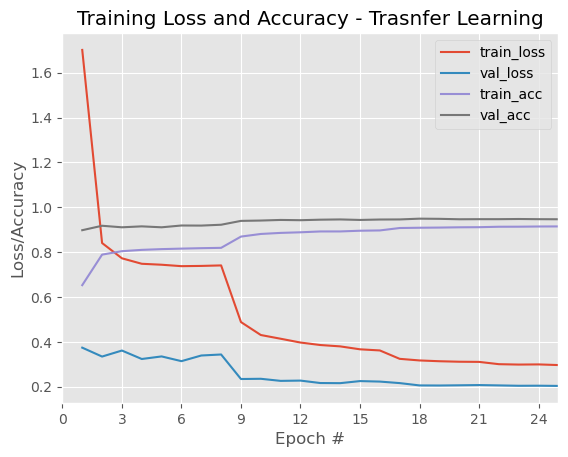

In [ ]:
# Gráficas con datos de historial de entrenamiento del generador
n_epochs = n_epochs
plt.style.use("ggplot")
plt.figure()
epochs_plt = np.arange(1, n_epochs + 1)  # Crear un rango de 1 a n_epochs
plt.plot(epochs_plt, H1.history["loss"], label="train_loss")
plt.plot(epochs_plt, H1.history["val_loss"], label="val_loss")
plt.plot(epochs_plt, H1.history["accuracy"], label="train_acc")
plt.plot(epochs_plt, H1.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy - Trasnfer Learning")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim([0, n_epochs])
plt.legend()
plt.show()

In [ ]:
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = transfer_model.predict(test_generator, verbose=1)

# Obtenemos las etiquetas reales (ground truth)
y_test = []
for i in range(len(test_generator)):
    batch = test_generator[i]
    y_test.extend(np.argmax(batch[1], axis=1))

# Obtenemos las etiquetas predichas
y_pred = np.argmax(predictions, axis=1)

# Generamos el informe de clasificación
print(classification_report(y_test, y_pred, zero_division=1))

[INFO]: Evaluando red neuronal...
42/42 [==============================] - 5s 86ms/step
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      0.60      0.75         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.80      0.80      0.80         5
          13       1.00      0.60      0.75         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00    

### TRASFER LEARNING: VGG16

In [ ]:
# Normalizamos las entradas de idéntica forma a como lo hicieron para entrenar efficientnet_v2 en imageNet y añadimos data augmentation
data_augmentation = True

if data_augmentation:
    train_datagen = ImageDataGenerator(
        preprocessing_function=vgg16_preprocess_input,
        rotation_range=10,
        zoom_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest"
    )

else:
    train_datagen = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess_input
)


valid_datagen = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess_input
)

# Tamaño de batches para cada set
train_batch = 128
valid_batch = 64
test_batch = 64

# Cargar los datos usando los generadores de flujo de directorio
# Reducimos el tamaño de las imágenes de train para agilizar el entrenamiento (recomendado en la web del dataset)
train_generator = train_datagen.flow_from_directory(
    directory="dataset/train/",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=train_batch,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory="dataset/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=valid_batch,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory="dataset/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=test_batch,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
# Usamos EfficientNetV2B0, con pesos de ImageNet y sin Top_Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Conectamos a Top Model con los pesos congelados
base_model.trainable = False
transfer_model = Sequential()
transfer_model.add(base_model)
transfer_model.add(GlobalMaxPooling2D())
transfer_model.add(Flatten())
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(525, activation='softmax'))
transfer_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_max_pooling2d_6 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_15 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 525)              

In [ ]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")

# EarlyStopping para que deje de entrenar si se produce overfitting
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 4,
                               mode = "min",
                               restore_best_weights = False)

# ReduceLROnPlateau para que reduzca el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.2, patience=2, min_lr=1e-6)

optimizer = Adam(learning_rate=0.01)

transfer_model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

[INFO]: Compilando el modelo...


In [ ]:
# Entrenamiento de la red
n_epochs = 25

print("[INFO]: Entrenando la red...")
H2 = transfer_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_batch,
    epochs=n_epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_batch,
    callbacks = [reduce_lr, early_stopping]
)

[INFO]: Entrenando la red...
Epoch 1/25
661/661 [==============================] - 420s 635ms/step - loss: 2.1718 - accuracy: 0.5258 - val_loss: 0.9291 - val_accuracy: 0.7664 - lr: 0.0100
Epoch 2/25
661/661 [==============================] - 413s 624ms/step - loss: 1.4168 - accuracy: 0.6582 - val_loss: 0.8188 - val_accuracy: 0.7896 - lr: 0.0100
Epoch 3/25
661/661 [==============================] - 415s 628ms/step - loss: 1.2863 - accuracy: 0.6834 - val_loss: 0.7912 - val_accuracy: 0.7965 - lr: 0.0100
Epoch 4/25
661/661 [==============================] - 413s 625ms/step - loss: 1.2410 - accuracy: 0.6926 - val_loss: 0.7689 - val_accuracy: 0.7957 - lr: 0.0100
Epoch 5/25
661/661 [==============================] - 409s 619ms/step - loss: 1.2043 - accuracy: 0.6986 - val_loss: 0.7802 - val_accuracy: 0.7965 - lr: 0.0100
Epoch 6/25
661/661 [==============================] - 408s 617ms/step - loss: 1.1847 - accuracy: 0.7039 - val_loss: 0.7072 - val_accuracy: 0.8216 - lr: 0.0100
Epoch 7/25
661/66

In [ ]:
# Almacenamos el modelo y el historial del entrenamiento
with open('VGG16_history.pkl', 'wb') as file:
    pickle.dump(H2.history, file)

transfer_model.save(BASE_FOLDER+"VGG16_model.h5")

# transfer_model = tf.keras.models.load_model(BASE_FOLDER+'VGG16_model.h5')

In [ ]:
# Evaluación del modelo con generadores de flujo de datos
print("[INFO]: Evaluando el modelo...")
test_loss, test_accuracy = transfer_model.evaluate(test_generator)

# Imprimir la pérdida y precisión en el conjunto de prueba
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

[INFO]: Evaluando el modelo...
42/42 [==============================] - 8s 178ms/step - loss: 0.4655 - accuracy: 0.8663
Test Loss: 0.4655185043811798
Test Accuracy: 0.8662857413291931


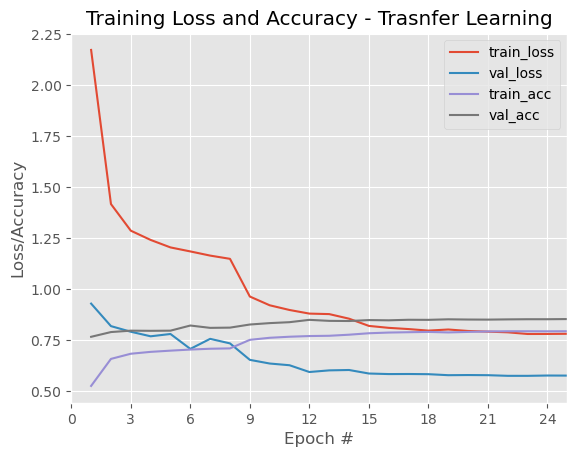

In [ ]:
# Gráficas con datos de historial de entrenamiento del generador
n_epochs = n_epochs
plt.style.use("ggplot")
plt.figure()
epochs_plt = np.arange(1, n_epochs + 1)  # Crear un rango de 1 a n_epochs
plt.plot(epochs_plt, H2.history["loss"], label="train_loss")
plt.plot(epochs_plt, H2.history["val_loss"], label="val_loss")
plt.plot(epochs_plt, H2.history["accuracy"], label="train_acc")
plt.plot(epochs_plt, H2.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy - Trasnfer Learning")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim([0, n_epochs])
plt.legend()
plt.show()

In [ ]:
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = transfer_model.predict(test_generator, verbose=1)

# Obtenemos las etiquetas reales (ground truth)
y_test = []
for i in range(len(test_generator)):
    batch = test_generator[i]
    y_test.extend(np.argmax(batch[1], axis=1))

# Obtenemos las etiquetas predichas
y_pred = np.argmax(predictions, axis=1)

# Generamos el informe de clasificación
print(classification_report(y_test, y_pred, zero_division=1))

[INFO]: Evaluando red neuronal...
42/42 [==============================] - 8s 188ms/step
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       1.00      0.40      0.57         5
           2       0.83      1.00      0.91         5
           3       0.83      1.00      0.91         5
           4       1.00      0.60      0.75         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.20      0.33         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      0.60      0.75         5
          13       1.00      0.20      0.33         5
          14       1.00      1.00      1.00         5
          15       1.00      0.80      0.89   

### Justificación

1. Obtenemos mejores resultados al utilizar la red EfficientNetV2B0 como extractor de características comparado con los resultados obtenidos con VGG16.
2. Se utilizaron versiones de los modelos presentados algo más complejas, pero se llegaba con ellas a resultados de overfitting y los entrenamientos se hacían demasiado largos.
3. La elección del Top Model implementado se basó en la necesidad de encontrar un equilibrio entre la complejidad del modelo y la capacidad de generalización. Especialmente cuando se enfrenta a un problema de clasificación con un gran número de clases. En este caso, la tarea implica clasificar imágenes en 525 clases diferentes, lo que puede llevar a un rápido crecimiento en el número de parámetros.
4. Finalmente, en ambos casos se observa que no se llega a alcanzar overfitting, en todo caso lo contrario, con lo que quizá se podría haber ajustado un poco más a la baja el dropout impuesto o incluso otorgar un mayor número de épocas al entrenamiento.


### FINE TUNNING: VGG16

In [ ]:
# Normalizamos las entradas de idéntica forma a como lo hicieron para entrenar VGG16 en imageNet y añadimos data augmentation
data_augmentation = True

if data_augmentation:
    train_datagen = ImageDataGenerator(
        preprocessing_function=vgg16_preprocess_input,
        rotation_range=10,
        zoom_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest"
    )

else:
    train_datagen = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess_input
)


valid_datagen = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=vgg16_preprocess_input
)

# Tamaño de batches para cada set
train_batch = 128
valid_batch = 64
test_batch = 64

# Cargar los datos usando los generadores de flujo de directorio
# Reducimos el tamaño de las imágenes de train para agilizar el entrenamiento (recomendado en la web del dataset)
train_generator = train_datagen.flow_from_directory(
    directory="dataset/train/",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=train_batch,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory="dataset/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=valid_batch,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory="dataset/test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=test_batch,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
# Importamos la arquitectura de la red con pesos de ImageNet y sin Top_Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Congelamos las capas de todos los bloques excepto la última capa del último bloque
for layer in base_model.layers:
  if layer.name == 'block5_conv3':
    break
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada...')

Capa input_9 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...
Capa block3_conv1 congelada...
Capa block3_conv2 congelada...
Capa block3_conv3 congelada...
Capa block3_pool congelada...
Capa block4_conv1 congelada...
Capa block4_conv2 congelada...
Capa block4_conv3 congelada...
Capa block4_pool congelada...
Capa block5_conv1 congelada...
Capa block5_conv2 congelada...


In [ ]:
# Conectamos a Top Model
ft_model = Sequential()
ft_model.add(base_model)
ft_model.add(GlobalMaxPooling2D())
ft_model.add(Flatten())
ft_model.add(BatchNormalization())
ft_model.add(Dropout(0.5))
ft_model.add(Dense(525, activation='softmax'))
ft_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_max_pooling2d_9 (Glo  (None, 512)              0         
 balMaxPooling2D)                                                
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_18 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 525)              

In [ ]:
# Compilar el modelo
print("[INFO]: Compilando el modelo...")

# EarlyStopping para que deje de entrenar si se produce overfitting
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 4,
                               mode = "min",
                               restore_best_weights = False)

# ReduceLROnPlateau para que reduzca el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.2, patience=3, min_lr=1e-5)

optimizer = Adam(learning_rate=0.05)

ft_model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

[INFO]: Compilando el modelo...


In [ ]:
# Entrenamiento de la red
n_epochs = 25

print("[INFO]: Entrenando la red...")
H3 = ft_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_batch,
    epochs=n_epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_batch,
    callbacks = [reduce_lr, early_stopping]
)

[INFO]: Entrenando la red...
Epoch 1/25
661/661 [==============================] - 418s 631ms/step - loss: 3.2673 - accuracy: 0.4130 - val_loss: 1.9353 - val_accuracy: 0.6673 - lr: 0.0500
Epoch 2/25
661/661 [==============================] - 412s 623ms/step - loss: 3.1911 - accuracy: 0.5499 - val_loss: 2.1816 - val_accuracy: 0.6966 - lr: 0.0500
Epoch 3/25
661/661 [==============================] - 413s 624ms/step - loss: 3.6050 - accuracy: 0.5985 - val_loss: 3.0371 - val_accuracy: 0.7359 - lr: 0.0500
Epoch 4/25
661/661 [==============================] - 412s 624ms/step - loss: 3.6972 - accuracy: 0.6403 - val_loss: 4.4386 - val_accuracy: 0.7450 - lr: 0.0500
Epoch 5/25
661/661 [==============================] - 413s 624ms/step - loss: 1.2257 - accuracy: 0.7590 - val_loss: 0.6216 - val_accuracy: 0.8617 - lr: 0.0100
Epoch 6/25
661/661 [==============================] - 409s 619ms/step - loss: 0.8801 - accuracy: 0.7877 - val_loss: 0.5449 - val_accuracy: 0.8605 - lr: 0.0100
Epoch 7/25
661/66

In [ ]:
# Almacenamos el modelo y el historial del entrenamiento
with open('VGG16FT_history.pkl', 'wb') as file:
    pickle.dump(H3.history, file)

ft_model.save(BASE_FOLDER+"VGG16FT.h5")

# ft_model = tf.keras.models.load_model(BASE_FOLDER+'VGG16FT_model.h5')

In [ ]:
# Evaluación del modelo con generadores de flujo de datos
print("[INFO]: Evaluando el modelo...")
test_loss, test_accuracy = ft_model.evaluate(test_generator)

# Imprimir la pérdida y precisión en el conjunto de prueba
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

[INFO]: Evaluando el modelo...
42/42 [==============================] - 8s 177ms/step - loss: 0.2626 - accuracy: 0.9310
Test Loss: 0.26260828971862793
Test Accuracy: 0.9310476183891296


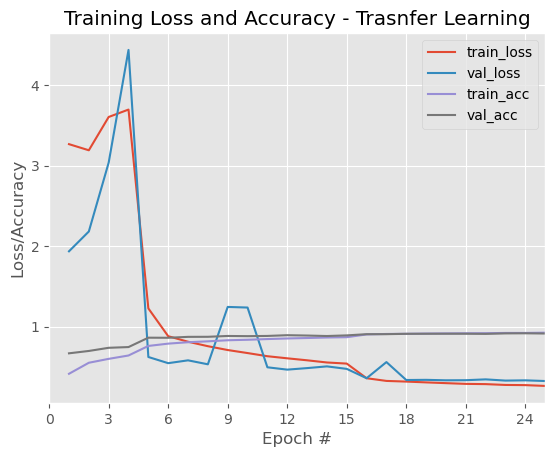

In [ ]:
# Gráficas con datos de historial de entrenamiento del generador
n_epochs = n_epochs
plt.style.use("ggplot")
plt.figure()
epochs_plt = np.arange(1, n_epochs + 1)  # Crear un rango de 1 a n_epochs
plt.plot(epochs_plt, H3.history["loss"], label="train_loss")
plt.plot(epochs_plt, H3.history["val_loss"], label="val_loss")
plt.plot(epochs_plt, H3.history["accuracy"], label="train_acc")
plt.plot(epochs_plt, H3.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy - Trasnfer Learning")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim([0, n_epochs])
plt.legend()
plt.show()

In [ ]:
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = ft_model.predict(test_generator, verbose=1)

# Obtenemos las etiquetas reales (ground truth)
y_test = []
for i in range(len(test_generator)):
    batch = test_generator[i]
    y_test.extend(np.argmax(batch[1], axis=1))

# Obtenemos las etiquetas predichas
y_pred = np.argmax(predictions, axis=1)

# Generamos el informe de clasificación
print(classification_report(y_test, y_pred, zero_division=1))

[INFO]: Evaluando red neuronal...
42/42 [==============================] - 8s 178ms/step
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5
           2       0.83      1.00      0.91         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.60      0.75         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      0.80      0.89         5
          13       1.00      0.60      0.75         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00   

### Justificación

1. Aunque la arquitectura VGG16 ha sido ampliamente utilizada en tareas de computer vision los resultados obtenidos en nuestro contexto no han sido tan satisfactorios como se esperaba. Por este motivo, se ha tomado la decisión de explorar la alternativa del Fine Tunnig para mejorar el comportamiento de este modelo.
2. Se descongeló el último bloque convolucional, pero se llegaba a cierto overfitting, así que finalmente solo quedó descongelada la última capa, obteniendo con ello resultados considerablemente mejores que con Transfer Learning.

## CONCLUSIONES

1. La gran cantidad de imágenes a tratar y su resolución ha impuesto condiciones exigentes a nivel de computación, por ello se han tenido que reducir las dimensiones de las imágenes del conjunto de train. Aun así los entrenamientos con la GPU en local han sido lentos, por lo que hemos tenido que ser cautelosos a la hora de realizar cambios sobre los modelos antes de realizar un nuevo entrenamiento.
2. Las clases parecen estar bien balanceadas y se obtienen resultados razonables para casi todas ellas, es decir, el dataset es de gran calidad.
3. Todas las estrategias parecen aportar resultados razonables, aunque claramente el mejor modelo es el obtenido con Transfer Learning para EfficientNetV2B0. Si tuviesemos que continuar investigando un mejor modelo para la tarea dada, no dudaríamos en seguir desarrollando sobre esta base, modificando el Top Model o incluso haciendo uso de Fine Tuning.
4. No obstante, con la estrategia From Scratch se obtienen buenos resultados y podría servir como una buena base para seguir investigando en busca de mejores resultados.